In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset 1: bananas y naranjas
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification
!unzip -q fruits-fresh-and-rotten-for-classification.zip -d ./dataset1

# Dataset 2: mangos
!kaggle datasets download -d filipemonteir/fresh-and-rotten-fruits-and-vegetables
!unzip -q fresh-and-rotten-fruits-and-vegetables.zip -d ./dataset2


Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.57G/3.58G [00:31<00:00, 219MB/s]
100% 3.58G/3.58G [00:31<00:00, 122MB/s]
Dataset URL: https://www.kaggle.com/datasets/filipemonteir/fresh-and-rotten-fruits-and-vegetables
License(s): unknown
 91% 580M/638M [00:03<00:00, 103MB/s] 
100% 638M/638M [00:03<00:00, 182MB/s]


In [ ]:
import os
import shutil

output_base = './frutas_completo'
clases = [
    ('freshbanana', './dataset1/dataset/train/freshbanana'),
    ('rottenbanana', './dataset1/dataset/train/rottenbanana'),
    ('freshoranges', './dataset1/dataset/train/freshoranges'),
    ('rottenoranges', './dataset1/dataset/train/rottenoranges'),
    ('freshmango', './dataset2/Dataset/Visual_Dataset/Train/FreshMango'),
    ('rottenmango', './dataset2/Dataset/Visual_Dataset/Train/RottenMango'),
]


for clase, ruta in clases:
    destino = os.path.join(output_base, 'train', clase)
    os.makedirs(destino, exist_ok=True)
    if os.path.exists(ruta):
        for fname in os.listdir(ruta):
            src = os.path.join(ruta, fname)
            dst = os.path.join(destino, fname)
            if os.path.isfile(src):
                shutil.copy(src, dst)


for clase, ruta in clases:
    test_ruta = ruta.replace('Train', 'Test')
    destino = os.path.join(output_base, 'test', clase)
    os.makedirs(destino, exist_ok=True)
    if os.path.exists(test_ruta):
        for fname in os.listdir(test_ruta)[-10:]:
            src = os.path.join(test_ruta, fname)
            dst = os.path.join(destino, fname)
            if os.path.isfile(src):
                shutil.copy(src, dst)

print("✅ Datos reorganizados con éxito")

✅ Datos reorganizados con éxito


In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

data_dir = './frutas_completo'

data_transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print("Clases detectadas:", class_names)

Clases detectadas: ['freshbanana', 'freshmango', 'freshoranges', 'rottenbanana', 'rottenmango', 'rottenoranges']


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 6)  # 6 clases

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Época {epoch+1} - Pérdida: {running_loss:.4f}")

Época 1 - Pérdida: 132.8944
Época 2 - Pérdida: 46.9696
Época 3 - Pérdida: 33.6712
Época 4 - Pérdida: 14.3215
Época 5 - Pérdida: 14.0493


In [ ]:
# Guarda el modelo entrenado
torch.save(model.state_dict(), 'modelo_frutas.pth')
print("✅ Modelo guardado como 'modelo_frutas.pth'")

✅ Modelo guardado como 'modelo_frutas.pth'


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in data_loader['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Precisión en test: {100 * correct / total:.2f}%")

Precisión en test: 95.00%


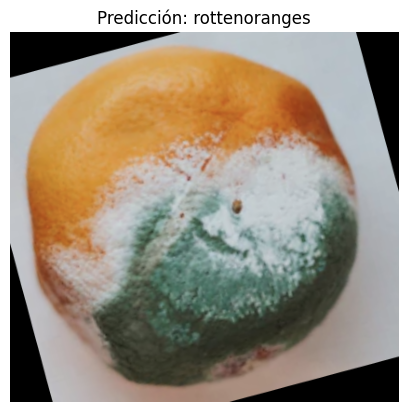

In [ ]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Ruta de la imagen
image_path = '/content/frutas_completo/test/rottenoranges/rotated_by_15_Screen Shot 2018-06-12 at 11.41.35 PM.png'

# Cargar y preprocesar la imagen
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Realizar predicción
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)


class_names = ['freshbanana', 'freshmango', 'freshoranges', 'rottenbanana', 'rottenmango', 'rottenoranges']


# Mostrar imagen y resultado
plt.imshow(img)
plt.title(f'Predicción: {class_names[predicted.item()]}')
plt.axis('off')
plt.show()